In [1]:
import pandas as pd

In [2]:
housing = pd.read_csv('dataset/housing/housing.csv')

In [3]:
housing.shape

(20640, 10)

In [4]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


<module 'matplotlib' from 'C:\\Users\\Playdata\\anaconda3\\lib\\site-packages\\matplotlib\\__init__.py'>

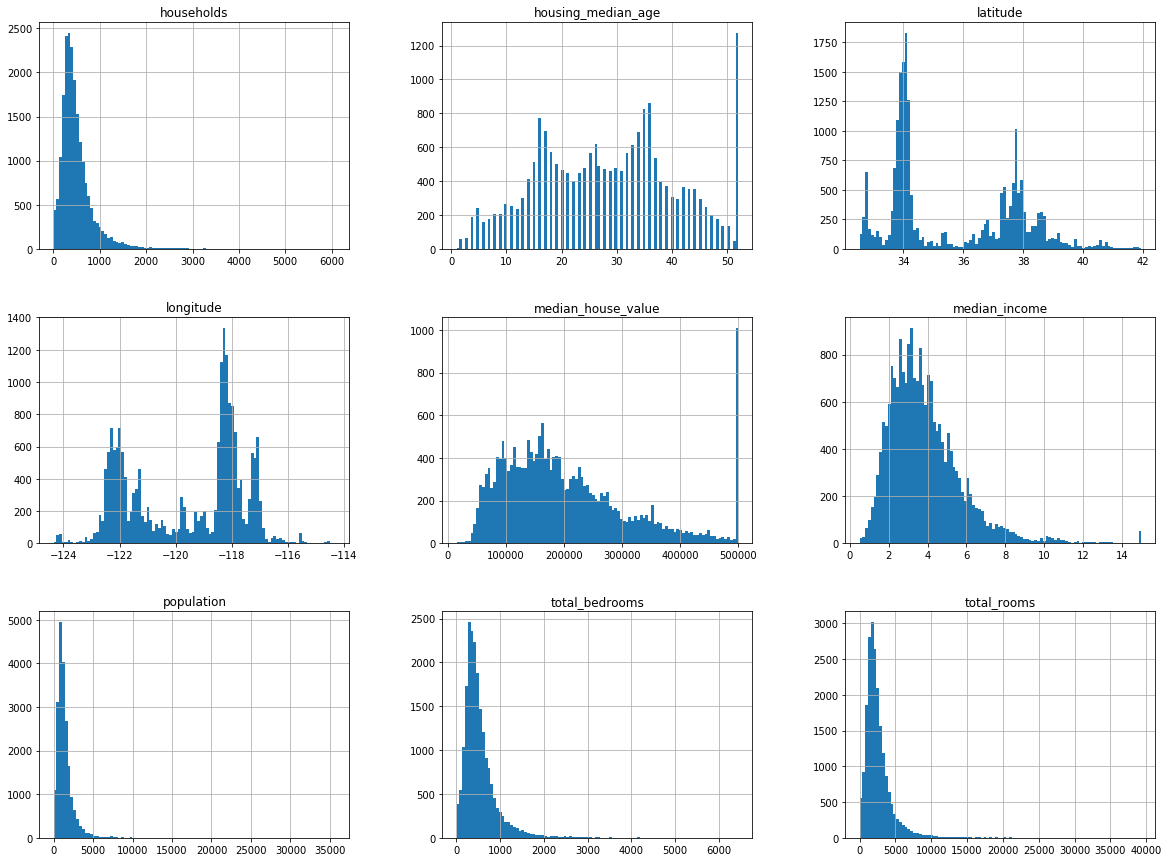

In [12]:
%matplotlib inline
import matplotlib as plt
housing.hist(bins=100,figsize=(20,15))
plt

## 테스트세트 만들기

In [7]:
# 난수를 이용한 방법

import numpy as np

def split_train_test(data, test_ratio):
    
    np.random.seed(42) # 랜덤 초기 값설정으로 매번 실행해도 같은 테스트세트를 만들 수 있다.
    shuffled_indicecs = np.random.permutation(len(data)) # 랜덤 배열 생성
    test_set_size = int(len(data) * test_ratio) 
    test_indices = shuffled_indicecs[:test_set_size] 
    train_indices = shuffled_indicecs[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
train_set, test_set = split_train_test(housing,0.2)
print(len(train_set),len(test_set))

16512 4128


In [9]:
# hash값을 이용한 방법, 식별자로 사용할 column 이 있는경우에 사용가능하다. 없으면 만들던지

from zlib import crc32

def test_set_check(indentifier, test_ratio):
    
    return crc32(np.int64(indentifier)) & 0xffffffff < test_ratio * 2**32 # hash 비트연산 후 최댓값 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
# 사이킷런의 train_test_split(), index를 기반으로 나눈다. 여러 df를 동시에 나눌 수 있다.(레이블 df가 따로 있을 때 유효), random_state 지정가능
from sklearn.model_selection import train_test_split

train_set,test_set = train_test_split(housing,test_size=0.2,random_state=42)
print(len(train_set),len(test_set))

16512 4128


## 계층적 샘플링

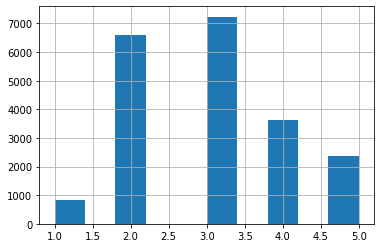

In [13]:
# 연속형 변수 범주형으로 만들기

# housing df에서 median_income 의 값을 기준으로 카테고리를 나누었다.
housing["income_cat"] = pd.cut(housing['median_income'],bins=[0,1.5,3.0,4.5,6,np.inf],labels=[1,2,3,4,5])
housing['income_cat'].hist()

In [14]:
#사이킷런의 StratifiedShuffleSplit() 함수
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

for train_index, test_index in split.split(housing,housing['income_cat']): # list로 인덱스를 반환
    start_train_set = housing.loc[train_index]
    start_test_set = housing.loc[test_index]

In [19]:
# income_cat 비율확인

a = start_train_set['income_cat'].value_counts()/len(start_train_set)

In [20]:
b = housing['income_cat'].value_counts()/len(housing)

In [30]:
df = pd.concat([b,a],axis=1)
df

,income_cat,income_cat
3,0.350581,0.350594
2,0.318847,0.318859
4,0.176308,0.176296
5,0.114438,0.114402
1,0.039826,0.039850


# 데이터 시각화

In [31]:
# 데이터 카피
housing = start_train_set.copy()

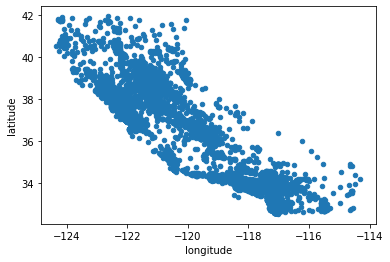

In [32]:
# 위도와 경도로 점찍기
housing.plot(kind='scatter',x='longitude',y='latitude')

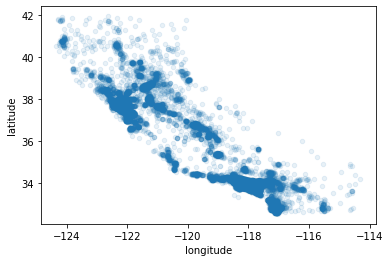

In [33]:
# alpha로 색 투명도 조절하여 밀집지역 찾기
housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.1)

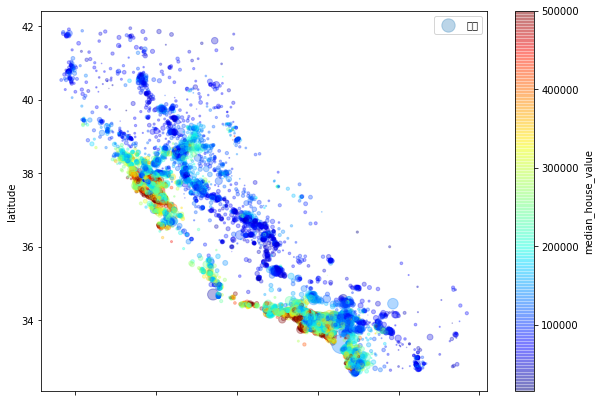

In [42]:
housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.3,
            s=housing['population']/100,label='인구',figsize=(10,7),
            c='median_house_value',cmap=plt.cm.get_cmap('jet'),colorbar=True)

# 인구수 : 원크기, 가격순 : 색으로 구분

## 상관관계 조사

In [47]:
corr_matrix = housing.corr() # 상관계수 구하기

corr_matrix['median_house_value'].sort_values(ascending=False) #ascending 오름차순

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018580655DC8>,
      dtype=object)

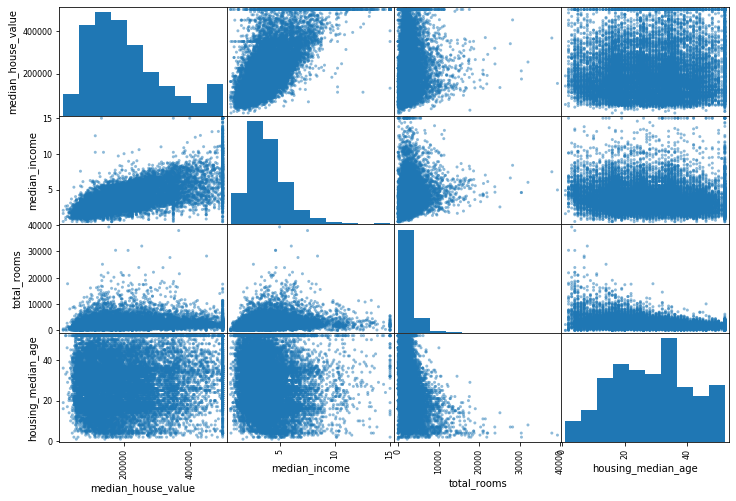

In [50]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(housing[attributes],figsize=(12,8))

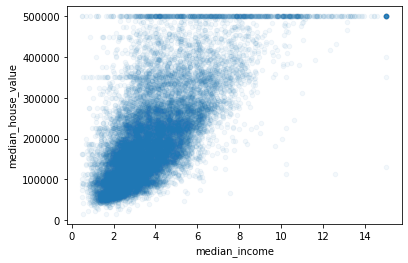

In [53]:
housing.plot(kind='scatter',x='median_income',y='median_house_value',alpha=0.05)

### 특성조합

In [ ]:
'''
1. 가구(구성원수)당 방의 수
2. 방 하나당 침대의 수
3. 가구당 인구 수
특성을 만들고 비교해본다.
'''

In [56]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [57]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending =False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# 데이터 정제

In [59]:
housing = start_train_set.drop('median_house_value',axis=1)
housing_labels = start_train_set['median_house_value'].copy()

In [61]:
# None 값 처리하기
# 1.행 버리기, 2.열버리기, 3.채워넣기

#사이킷런의 SimpleImputer 를 이용하여 채워넣기
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')

In [63]:
housing_num = housing.drop('ocean_proximity',axis=1) # 수치형 데이터만 median이 가능하다.
imputer.fit(housing_num) # median을 계산해서 statistics_ 속성으로 보관한다.
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [66]:
X = imputer.transform(housing_num) # 변경 후 다시 df로 만들어준다.
housing_tr = pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index)

### 텍스트와 범주형 데이터

In [67]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [68]:
# 사이킷런 OrdinalEncoder 클래스 사용

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [ ]:
# categories_ 속성을 통 카테고리 목록을 얻을 수 있다. 

In [72]:
# One-Hot 인코딩, 사이킷런의 OneHotEncoder 클래스 사용
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

## 변환기 만들기

In [73]:
from sklearn.base import BaseEstimator, TransformerMixin

room_ix,bedroom_ix,population_ix,households_ix = 3,4,5,6 # 각열의 번호

class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        rooms_per_household = X[:,room_ix]/X[:,households_ix]
        population_per_household = X[:,bedroom_ix]/X[:,households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedroom_ix]/X[:,room_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]

In [74]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## 파이프라인 만들기

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [76]:
num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('attr_adder', CombinedAttributesAdder()),
    ('std_scaler',StandardScaler()) # 표준화 스케일러
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [93]:
# 열별 다른 파이프라인 적용하기
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num) # column 이름을 가져온다.
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num',num_pipeline,num_attribs),
    ('cat',OneHotEncoder(),cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing) #numpy.ndarray 로 반환

array([-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
       -0.63621141, -0.42069842, -0.61493744, -0.95445595, -0.31205452,
       -0.1215581 ,  0.15531753,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

# 모델선택과 훈련

In [79]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [99]:
some_labels = housing_labels.iloc[:5]
some_data = full_pipeline.fit_transform(housing)
some_data_prepared = some_data[:5]
# lin_reg.predict(some_data_prepared)

In [100]:
print('예측 :',lin_reg.predict(some_data_prepared))
print('lable',list(some_labels))

예측 : [201234.58023536 325581.25687234 201824.80220993  58084.53812375
 191691.52187807]
lable [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


## 평가하기

In [101]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels,housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67919.51262615145

# 다른모델

In [102]:
from sklearn.tree import DecisionTreeRegressor # 비선형회귀

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [103]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels,housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# 교차검증

In [105]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(tree_reg, housing_prepared,housing_labels,scoring ='neg_mean_squared_error',cv=10) #10개 교차검증
tree_rmse_scores = np.sqrt(-score)
tree_rmse_scores

array([68775.17986112, 69934.19088867, 73729.05767993, 72495.75693791,
       70553.25094267, 72860.99376902, 70258.04719687, 71628.36320751,
       72632.35068984, 71930.71932743])

In [106]:
def display_score(score):
    print('점수:',score)
    print('평균:',score.mean())
    print('표준편차:',score.std())
    
display_score(tree_rmse_scores)

점수: [68775.17986112 69934.19088867 73729.05767993 72495.75693791
 70553.25094267 72860.99376902 70258.04719687 71628.36320751
 72632.35068984 71930.71932743]
평균: 71479.79105009892
표준편차: 1469.9608118774836


In [109]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels,housing_predictions)
forest_rmse = np.sqrt(forest_mse)
score = cross_val_score(forest_reg, housing_prepared,housing_labels,scoring ='neg_mean_squared_error',cv=10) #10개 교차검증
forest_reg_rmse_scores = np.sqrt(-score)
display_score(forest_reg_rmse_scores)

점수: [48601.66359987 46454.04354853 49882.36732787 51301.43412593
 49740.68864546 52919.95808928 49085.09513818 51518.4613659
 52124.92969457 50014.54482064]
평균: 50164.318635623415
표준편차: 1794.9491675122638
